# Лабораторная работ 5. Построение моделей сообществ

### Импорты

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle

## Подготовка данных

In [3]:
def unpickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

In [4]:
def remove_empty_friends(d):
    return {user: friends for user, friends in d.items() if friends}

In [5]:
friends_negotiation = remove_empty_friends(unpickle("friends_graph_negotiation_only.pickle"))
friends_theater = remove_empty_friends(unpickle("friends_graph_theater_only.pickle"))
friends_both = remove_empty_friends(unpickle("friends_graph_in_both.pickle"))

In [6]:
group_users = unpickle('group_users_dict.pickle')
users_negotiation = set(group_users['itmo_negotiations'])
users_theater = set(group_users['t3abtpa'])


only_negotiation = users_negotiation - users_theater
only_theater = users_theater - users_negotiation
both_groups = users_negotiation & users_theater

relevant_users = users_negotiation | users_theater


In [7]:


filtered_friends_negotiation = {
    k: [f for f in v if f in relevant_users] for k, v in friends_negotiation.items()
}
filtered_friends_theater = {
    k: [f for f in v if f in relevant_users] for k, v in friends_theater.items()
}
filtered_friends_both = {
    k: [f for f in v if f in relevant_users] for k, v in friends_both.items()
}

In [8]:
class GraphCreator:
    G = None
    categories = ["Only Negotiation", "Only Theater", "Both"]
    nodes = [only_negotiation, only_theater, both_groups]
    edges = [
        filtered_friends_negotiation,
        filtered_friends_theater,
        filtered_friends_both,
    ]

    color_map = {"Only Negotiation": "red", "Only Theater": "green", "Both": "blue"}

    def __init__(self, negotiation=False, theater=False, both=False):
        self.in_graph = [negotiation, theater, both]

    def get_colors(self):
        if self.G is None:
            raise Exception("no graph created")
        node_colors = []
        for node in self.G.nodes(data=True):
            try:
                category = node[1]["category"]
            except KeyError:
                print(node)
                break
            color = self.color_map[category]
            node_colors.append(color)
        return node_colors

    def create_graph(self):
        self.G = nx.Graph()
        self._fill_full_graph()
        self._remove_edges()
        return self.G

    def _fill_full_graph(self):
        for i in range(len(self.categories)):
            category = self.categories[i]
            nodes = self.nodes[i]
            edges = self.edges[i]
            self._add_nodes(nodes, category)
            self._add_edges(edges)
        return self.G

    def _remove_edges(self):
        categories_to_delete = []
        for i in range(len(self.categories)):
            in_graph = self.in_graph[i]
            category = self.categories[i]
            if not in_graph:
                categories_to_delete.append(category)

        nodes = list(self.G.nodes(data=True))
        for node in nodes:
            node_name = node[0]
            category = node[1]["category"]
            if category in categories_to_delete:
                self.G.remove_node(node_name)

    def _add_nodes(self, nodes, category):
        for node in nodes:
            self.G.add_node(node, category=category)

    def _add_edges(self, edges):
        for start, ends in edges.items():
            for end in ends:
                self.G.add_edge(start, end)

## Проанализируем сети по отдельности

### Клуб переговоров

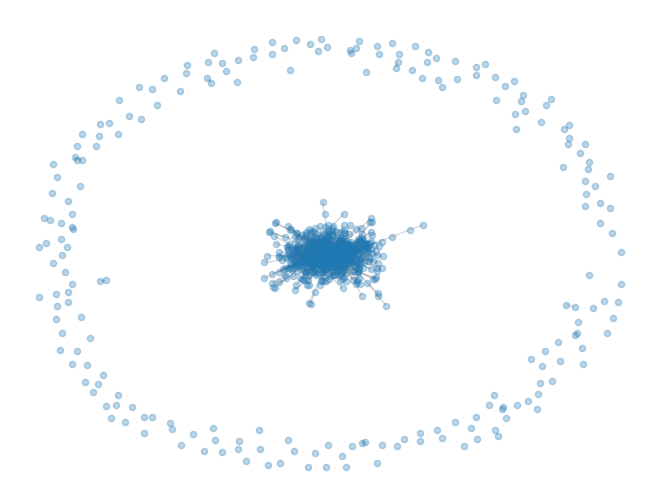

In [9]:
creator = GraphCreator(both=True, negotiation=True)

G = creator.create_graph()


pos = nx.spring_layout(G)  

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=20,
    edge_color="gray",
    alpha=0.3,
)

plt.show()


#### Распределение рангов вершин

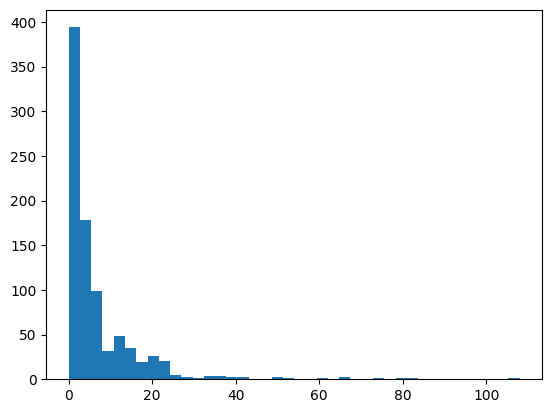

In [10]:
degrees = list(dict(G.degree()).values())
plt.hist(degrees, bins=40);

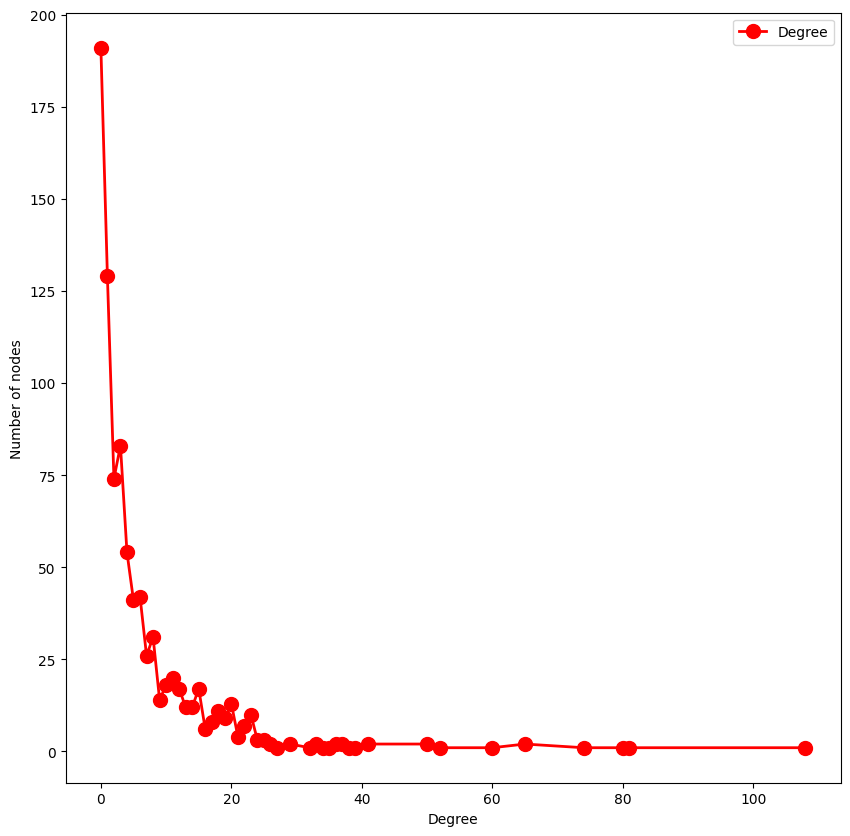

In [11]:
degree = dict(G.degree())
degree_values = sorted(set(degree.values()))
hist = [list(degree.values()).count(x) for x in degree_values]
plt.figure(figsize=(10, 10))
plt.plot(degree_values, hist, 'ro-', linewidth=2, markersize=10)
plt.legend(['Degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()

#### Кластерный коэффициент

In [12]:
cluster_coef = nx.average_clustering(G)
print(f'Кластерный коэффициент: {cluster_coef}')

Кластерный коэффициент: 0.19916075807441486


#### Среднее расстояние

Удалим пользователей без друзей

In [13]:
degrees = dict(G.degree())
for person, friends_count in degrees.items():
    if friends_count == 0:
        G.remove_node(person)

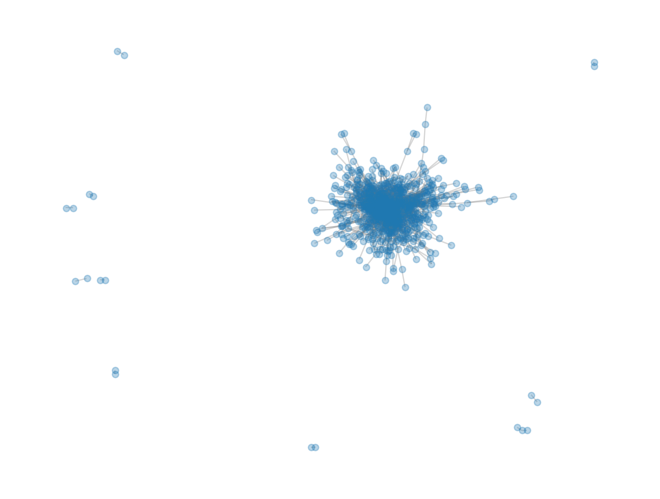

In [14]:
pos = nx.spring_layout(G)  

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=20,
    edge_color="gray",
    alpha=0.3,
)

plt.show()

Видим, что есть одна большая компонента связности и остальные поменьше.
Посчитаем среднее расстояние только в большой компоненте

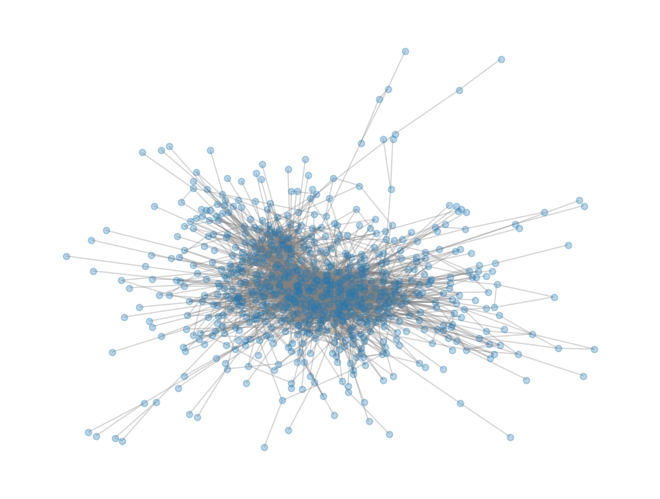

In [15]:
connected_components = nx.connected_components(G)


largest_component = max(connected_components, key=len)

G_largest_component = G.subgraph(largest_component).copy()

pos = nx.spring_layout(G_largest_component)  

nx.draw(
    G_largest_component,
    pos,
    with_labels=False,
    node_size=20,
    edge_color="gray",
    alpha=0.3,
)

plt.show()

Среднее расстояние

In [16]:
average_length = nx.average_shortest_path_length(G_largest_component)
print(f'Среднее расстояние: {average_length}')

Среднее расстояние: 3.458940765620482


Сравнение параметров с другими типами графов

In [ ]:
from scipy.linalg import LinAlgError
from scipy.stats import gaussian_kde

In [23]:


def get_distribution(G):
    degrees = list(dict(G.degree).values())
    kde = gaussian_kde(degrees)
    x = np.linspace(min(degrees), max(degrees), 1000)
    return x, kde(x)

def get_mean_distance(G):
    connected_components = nx.connected_components(G)
    largest_component = max(connected_components, key=len)
    G_largest_component = G.subgraph(largest_component).copy()
    average_length = nx.average_shortest_path_length(G_largest_component)
    return average_length
    
def get_clustering_coefficient(G):
    return nx.average_clustering(G)

In [25]:

def generate_erdos_renyi_graph(G):
    """
    Generate an Erdos-Renyi (ER) model graph based on the input graph G.
    """
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    p = num_edges / (num_nodes * (num_nodes - 1) / 2) 
    ER_model = nx.erdos_renyi_graph(num_nodes, p)
    return ER_model

def generate_barabasi_albert_graph(G):
    """
    Generate a Barabási-Albert (BA) model graph based on the input graph G.
    """
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    m = int(num_edges / num_nodes)  
    BA_model = nx.barabasi_albert_graph(num_nodes, m)
    return BA_model



def generate_random_geometric_graph(G):
    """
    Generate a Random Geometric Graph (RGG) based on the input graph G.
    """
    num_nodes = G.number_of_nodes()
    radius = (2 * G.number_of_edges() / (num_nodes * (num_nodes - 1))) ** 0.5  
    RGG_model = nx.random_geometric_graph(num_nodes, radius)
    return RGG_model

def generate_power_law_cluster_graph(G):
    """
    Generate a Power-Law Cluster Graph (PLCG) based on the input graph G.
    """
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    m = int(num_edges / num_nodes) 
    p = 0.1  
    PLCG_model = nx.powerlaw_cluster_graph(num_nodes, m, p)
    return PLCG_model

def generate_regular_graph(G):
    """
    Generate a Regular Graph based on the input graph G.
    """
    num_nodes = G.number_of_nodes()
    degree = int((2 * G.number_of_edges()) // num_nodes)  # Each node has this many edges
    Regular_model = nx.random_regular_graph(degree, num_nodes)
    return Regular_model

def generate_k_nearest_neighbors_graph(G):
    """
    Generate a K-Nearest Neighbors Graph (KNN) based on the input graph G.
    """
    num_nodes = G.number_of_nodes()
    k = int((2 * G.number_of_edges()) // num_nodes)  
    KNN_model = nx.watts_strogatz_graph(num_nodes, k, 0)  
    return KNN_model


def generate_my_graph(G):
    return G

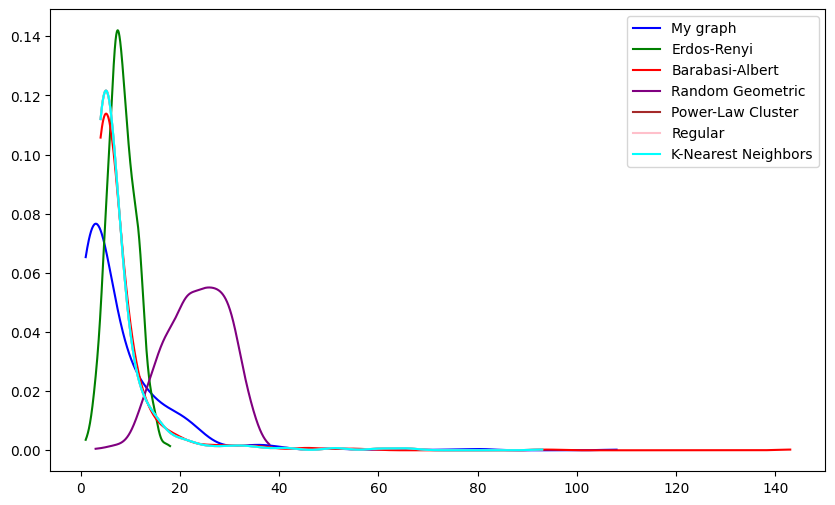

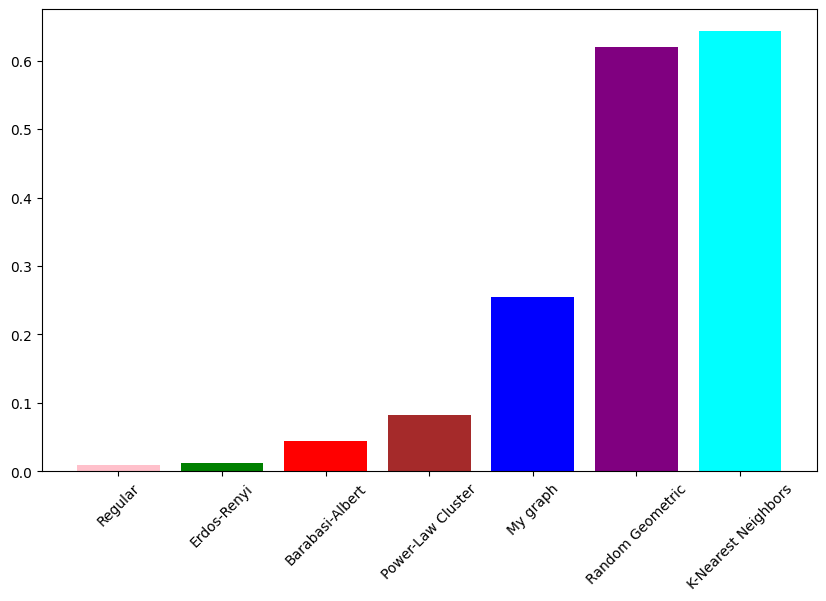

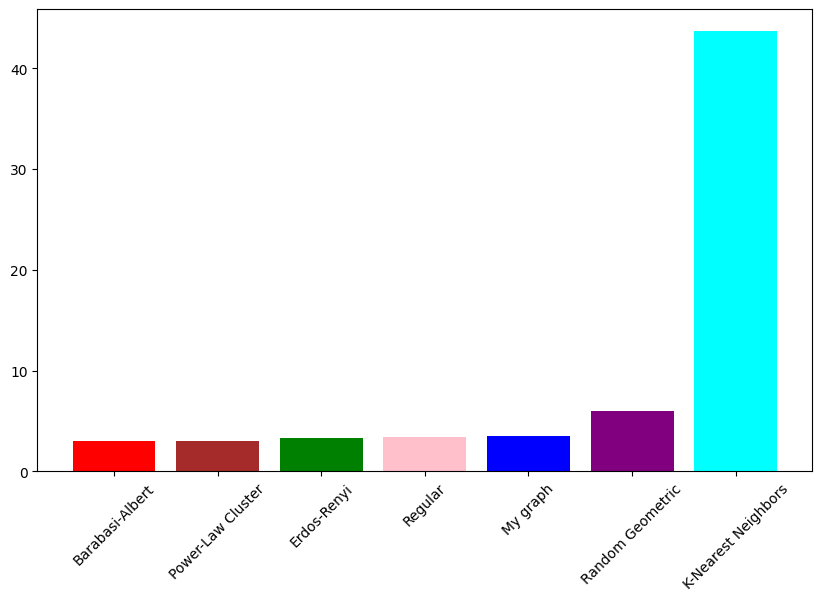

In [35]:
graph_types = [
    generate_my_graph,
    generate_erdos_renyi_graph,
    generate_barabasi_albert_graph,
    generate_random_geometric_graph,
    generate_power_law_cluster_graph,
    generate_regular_graph,
    generate_k_nearest_neighbors_graph,
]

colors = [
    'blue', 'green', 'red', 'purple', 'brown', 'pink', 'cyan'
]

labels = [
    'My graph', 'Erdos-Renyi',
    'Barabasi-Albert', 'Random Geometric', 'Power-Law Cluster', 
    'Regular', 'K-Nearest Neighbors'
]


# plot kdes
plt.figure(figsize=(10, 6))
for i in range(len(graph_types)):
    color = colors[i]
    label = labels[i]
    graph_type = graph_types[i]
    graph = graph_type(G)
    try:
        x, y = get_distribution(graph)
    except LinAlgError:
        pass
    plt.plot(x, y, label=label, c=color)
plt.legend()


def plot_bar_plot(compressed):
    values, colors, labels = zip(*compressed)
    plt.bar(labels, values, color=colors)
    plt.xticks(rotation=45)
    

plt.figure(figsize=(10, 6))
coefficients = [get_clustering_coefficient(type(G))  for type in graph_types]
zip_sorted = sorted(zip(coefficients, colors, labels), key=lambda x:x[0])
plot_bar_plot(zip_sorted)


plt.figure(figsize=(10, 6))
distances = [get_mean_distance(type(G))  for type in graph_types]
zip_sorted = sorted(zip(distances, colors, labels), key=lambda x:x[0])
plot_bar_plot(zip_sorted)

Наш граф не подходит ни под один из стандартных типов графов, однако идейно для него лучше всего подходит граф Barabasi-Albert

### Театр миниатюр

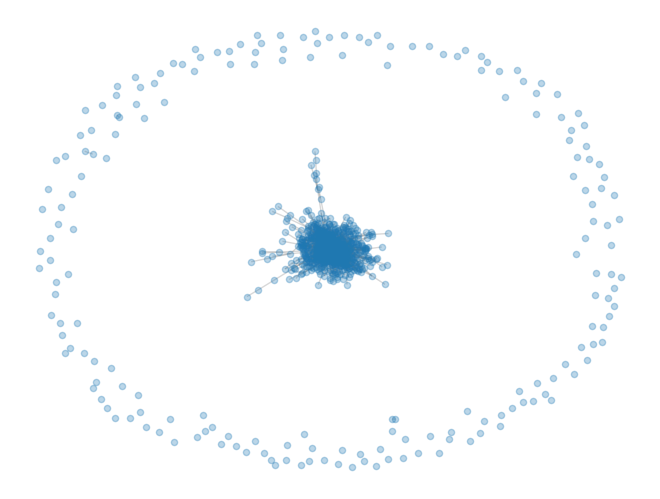

In [36]:
creator = GraphCreator(both=True, theater=True)

G = creator.create_graph()


pos = nx.spring_layout(G)  

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=20,
    edge_color="gray",
    alpha=0.3,
)

plt.show()


#### Распределение рангов вершин

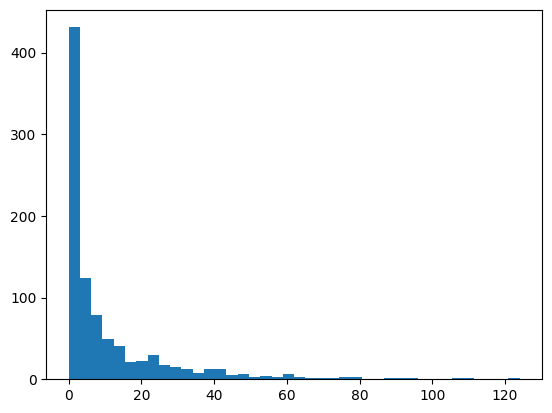

In [52]:
degrees = list(dict(G.degree()).values())
plt.hist(degrees, bins=40);

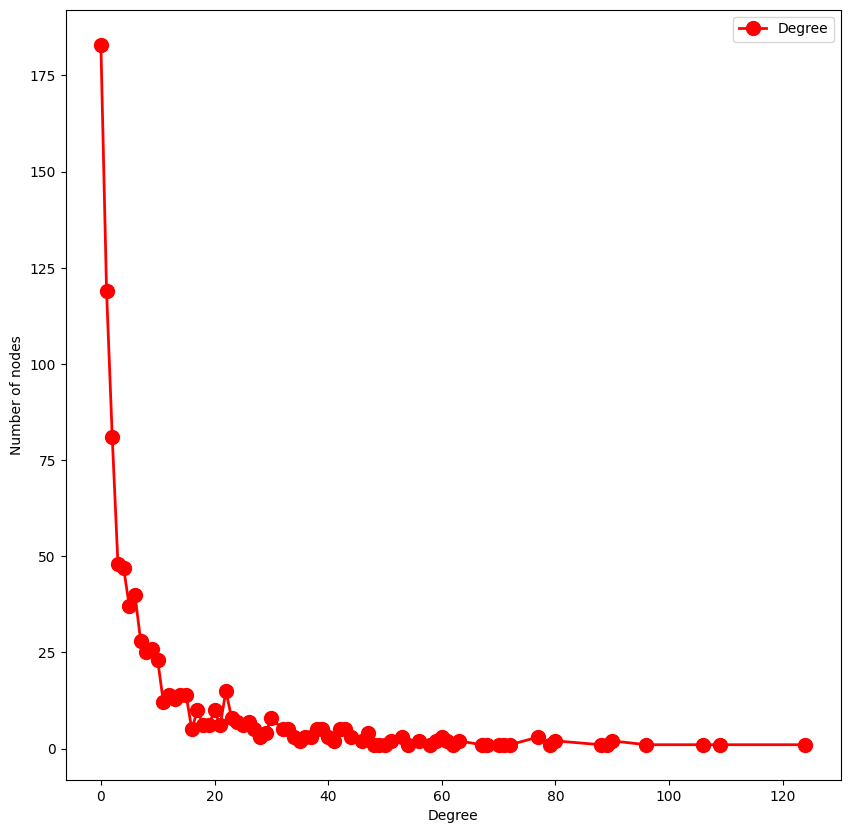

In [53]:
degree = dict(G.degree())
degree_values = sorted(set(degree.values()))
hist = [list(degree.values()).count(x) for x in degree_values]
plt.figure(figsize=(10, 10))
plt.plot(degree_values, hist, 'ro-', linewidth=2, markersize=10)
plt.legend(['Degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()

#### Кластерный коэффициент

In [54]:
cluster_coef = nx.average_clustering(G)
print(f'Кластерный коэффициент: {cluster_coef}')

Кластерный коэффициент: 0.24127258341640206


#### Среднее расстояние

Удалим пользователей без друзей

In [55]:
degrees = dict(G.degree())
for person, friends_count in degrees.items():
    if friends_count == 0:
        G.remove_node(person)

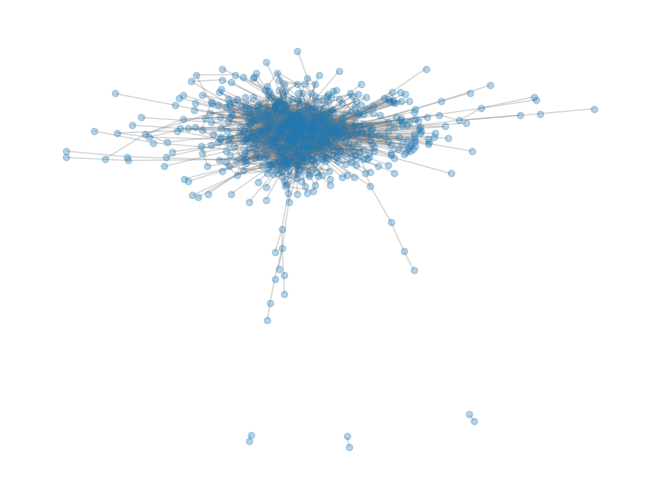

In [56]:
pos = nx.spring_layout(G)  

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=20,
    edge_color="gray",
    alpha=0.3,
)

plt.show()

Как и в ситуации с клубом переговоров есть одна большая компонента связности и остальные поменьше.
Посчитаем среднее расстояние только в большой компоненте

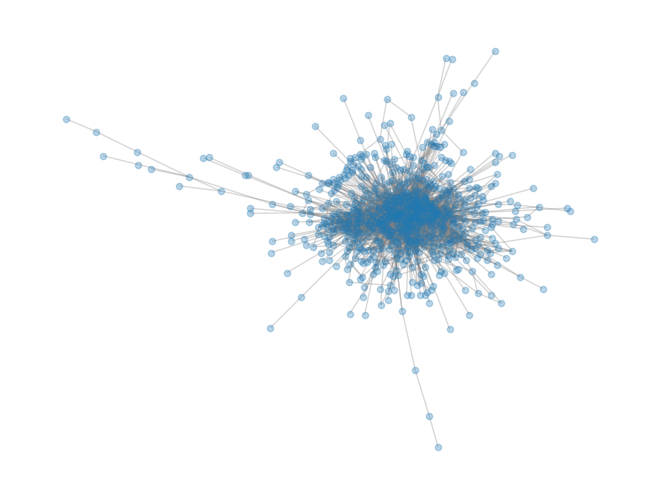

In [58]:
connected_components = nx.connected_components(G)


largest_component = max(connected_components, key=len)

G_largest_component = G.subgraph(largest_component).copy()

pos = nx.spring_layout(G_largest_component)  

nx.draw(
    G_largest_component,
    pos,
    with_labels=False,
    node_size=20,
    edge_color="gray",
    alpha=0.3,
)

plt.show()

Среднее расстояние

In [59]:
average_length = nx.average_shortest_path_length(G_largest_component)
print(f'Среднее расстояние: {average_length}')

Среднее расстояние: 3.189004336027373


Сравнение с другими типами графов

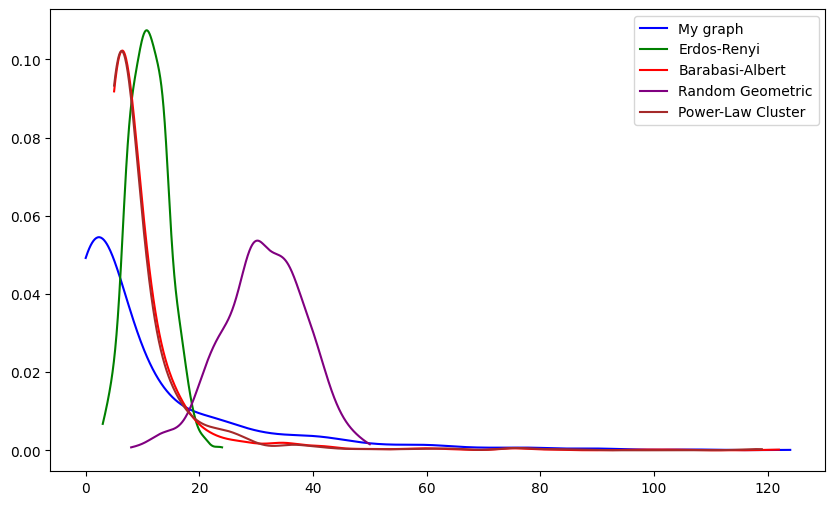

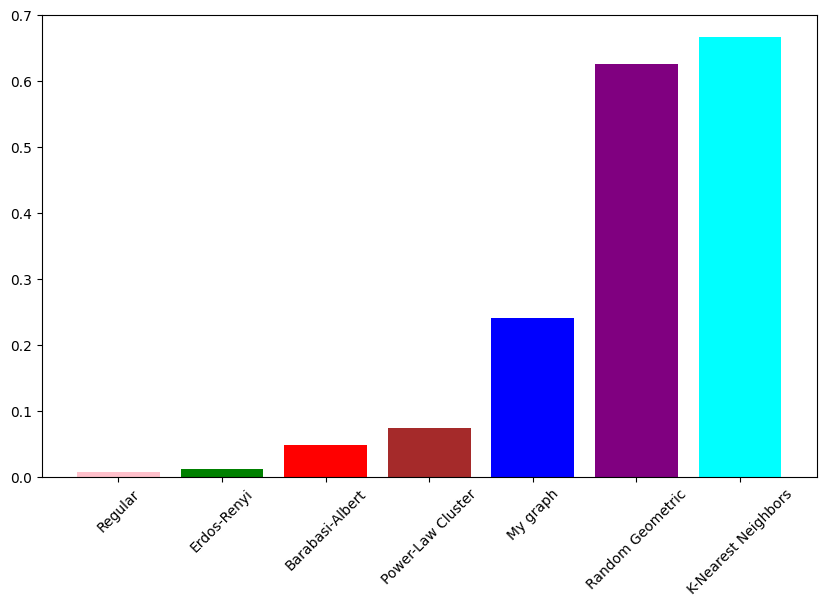

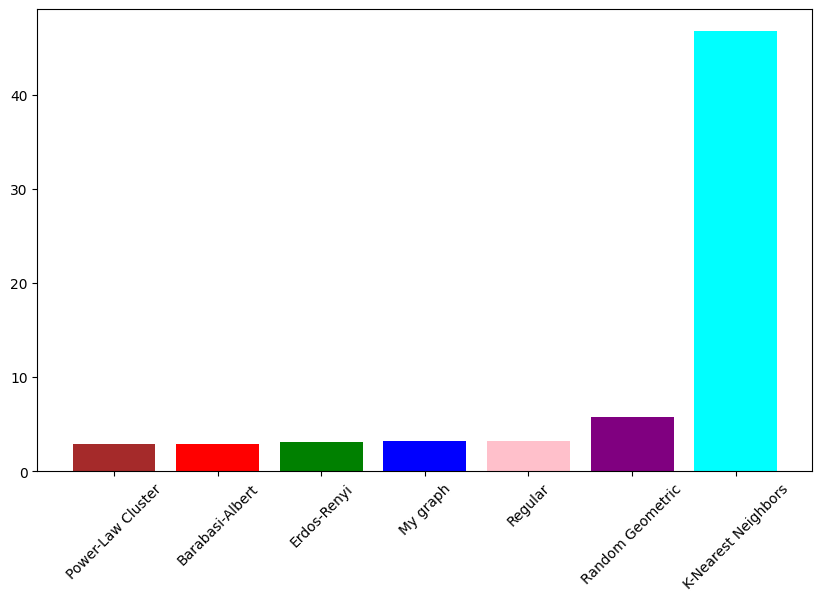

In [55]:
graph_types = [
    generate_my_graph,
    generate_erdos_renyi_graph,
    generate_barabasi_albert_graph,
    generate_random_geometric_graph,
    generate_power_law_cluster_graph,
    generate_regular_graph,
    generate_k_nearest_neighbors_graph,
]

colors = [
    'blue', 'green', 'red', 'purple', 'brown', 'pink', 'cyan'
]

labels = [
    'My graph', 'Erdos-Renyi',
    'Barabasi-Albert', 'Random Geometric', 'Power-Law Cluster', 
    'Regular', 'K-Nearest Neighbors'
]


# plot kdes
plt.figure(figsize=(10, 6))
for i in range(len(graph_types)-2):
    color = colors[i]
    label = labels[i]
    graph_type = graph_types[i]
    graph = graph_type(G)
    try:
        x, y = get_distribution(graph)
    except LinAlgError:
        pass
    plt.plot(x, y, label=label, c=color)
plt.legend()


def plot_bar_plot(compressed):
    values, colors, labels = zip(*compressed)
    plt.bar(labels, values, color=colors)
    plt.xticks(rotation=45)
    

plt.figure(figsize=(10, 6))
coefficients = [get_clustering_coefficient(type(G))  for type in graph_types]
zip_sorted = sorted(zip(coefficients, colors, labels), key=lambda x:x[0])
plot_bar_plot(zip_sorted)


plt.figure(figsize=(10, 6))
distances = [get_mean_distance(type(G))  for type in graph_types]
zip_sorted = sorted(zip(distances, colors, labels), key=lambda x:x[0])
plot_bar_plot(zip_sorted)

Видим, что как и в случае с клубом переговоров наш граф не подходит ни под один из стандартных типов графов, однако идейно для него лучше всего подходит граф Barabasi-Albert

## Сравнение сообществ

| Показатель/сообщество  | Клуб Переговоров | Театр Миниатюр |
|------------------------|------------------|----------------|
| Распределение рангов   | Power Law        | Power Law      |
| Кластерный коэффициент | 0.25             | 0.24           |
| Среднее расстояние     | 3.45             | 3.18           |